## Use torchcam| for Grad-CAM pretrained is resnet18 and SE-block

In [7]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchcam.methods import GradCAM



# data folder path
data_dir = "/home/kevinluo/breast_density_classification/ultralytics/data_with_muscle"

# pre-processing
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
#conv3*3 block
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
#SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
#Res block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [9]:
# Define Dataset class
class BreastDensityDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []

        for i in range(1, 5):
            class_path = os.path.join(self.data_dir, f"breast_density{i}")
            for img_name in os.listdir(class_path):
                self.img_paths.append(os.path.join(class_path, img_name))
                self.labels.append(i - 1)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [10]:
# construct dataset and dataloader
image_datasets = {x: BreastDensityDataset(os.path.join(data_dir, x), data_transforms[x])
                  for x in ["train", "valid", "test"]}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ["train", "valid", "test"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "valid", "test"]}

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.91) #SGD --> Adam差很多

scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

Epoch 1/50
----------


100%|██████████| 953/953 [03:09<00:00,  5.02it/s]


Train Loss: 1.2023 Acc: 0.4701


100%|██████████| 107/107 [00:09<00:00, 11.02it/s]


Valid Loss: 1.7578 Acc: 0.3647
Epoch 2/50
----------


100%|██████████| 953/953 [03:08<00:00,  5.06it/s]


Train Loss: 1.0264 Acc: 0.5438


100%|██████████| 107/107 [00:08<00:00, 12.42it/s]


Valid Loss: 1.6010 Acc: 0.4235
Epoch 3/50
----------


100%|██████████| 953/953 [03:11<00:00,  4.98it/s]


Train Loss: 0.9911 Acc: 0.5714


100%|██████████| 107/107 [00:09<00:00, 11.09it/s]


Valid Loss: 1.1902 Acc: 0.5200
Epoch 4/50
----------


100%|██████████| 953/953 [03:13<00:00,  4.92it/s]


Train Loss: 0.9498 Acc: 0.5885


100%|██████████| 107/107 [00:09<00:00, 11.37it/s]


Valid Loss: 0.8831 Acc: 0.6212
Epoch 5/50
----------


100%|██████████| 953/953 [03:14<00:00,  4.91it/s]


Train Loss: 0.9078 Acc: 0.6089


100%|██████████| 107/107 [00:09<00:00, 11.00it/s]


Valid Loss: 5.2024 Acc: 0.4753
Epoch 6/50
----------


100%|██████████| 953/953 [03:23<00:00,  4.68it/s]


Train Loss: 0.8850 Acc: 0.6192


100%|██████████| 107/107 [00:10<00:00, 10.26it/s]


Valid Loss: 1.1521 Acc: 0.5318
Epoch 7/50
----------


100%|██████████| 953/953 [03:27<00:00,  4.59it/s]


Train Loss: 0.8648 Acc: 0.6268


100%|██████████| 107/107 [00:10<00:00, 10.64it/s]


Valid Loss: 0.9551 Acc: 0.5859
Epoch 8/50
----------


100%|██████████| 953/953 [03:29<00:00,  4.55it/s]


Train Loss: 0.7146 Acc: 0.7126


100%|██████████| 107/107 [00:09<00:00, 10.87it/s]


Valid Loss: 0.6515 Acc: 0.7294
Epoch 9/50
----------


100%|██████████| 953/953 [03:26<00:00,  4.62it/s]


Train Loss: 0.7014 Acc: 0.7110


100%|██████████| 107/107 [00:09<00:00, 11.29it/s]


Valid Loss: 0.6755 Acc: 0.7129
Epoch 10/50
----------


100%|██████████| 953/953 [03:15<00:00,  4.88it/s]


Train Loss: 0.6582 Acc: 0.7249


100%|██████████| 107/107 [00:09<00:00, 11.54it/s]


Valid Loss: 0.7512 Acc: 0.6871
Epoch 11/50
----------


100%|██████████| 953/953 [03:11<00:00,  4.97it/s]


Train Loss: 0.6480 Acc: 0.7362


100%|██████████| 107/107 [00:09<00:00, 11.85it/s]


Valid Loss: 0.6573 Acc: 0.7482
Epoch 12/50
----------


100%|██████████| 953/953 [03:09<00:00,  5.03it/s]


Train Loss: 0.6357 Acc: 0.7430


100%|██████████| 107/107 [00:09<00:00, 11.51it/s]


Valid Loss: 0.6634 Acc: 0.7294
Epoch 13/50
----------


100%|██████████| 953/953 [03:08<00:00,  5.06it/s]


Train Loss: 0.6254 Acc: 0.7517


100%|██████████| 107/107 [00:09<00:00, 11.51it/s]


Valid Loss: 0.6358 Acc: 0.7435
Epoch 14/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.15it/s]


Train Loss: 0.6238 Acc: 0.7499


100%|██████████| 107/107 [00:08<00:00, 12.13it/s]


Valid Loss: 0.6632 Acc: 0.7365
Epoch 15/50
----------


100%|██████████| 953/953 [03:03<00:00,  5.20it/s]


Train Loss: 0.6130 Acc: 0.7572


100%|██████████| 107/107 [00:08<00:00, 12.10it/s]


Valid Loss: 0.6644 Acc: 0.7294
Epoch 16/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.13it/s]


Train Loss: 0.5967 Acc: 0.7606


100%|██████████| 107/107 [00:09<00:00, 11.48it/s]


Valid Loss: 0.6558 Acc: 0.7318
Epoch 17/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.10it/s]


Train Loss: 0.5849 Acc: 0.7727


100%|██████████| 107/107 [00:09<00:00, 11.40it/s]


Valid Loss: 0.6481 Acc: 0.7294
Epoch 18/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.11it/s]


Train Loss: 0.5952 Acc: 0.7706


100%|██████████| 107/107 [00:09<00:00, 11.79it/s]


Valid Loss: 0.6348 Acc: 0.7294
Epoch 19/50
----------


100%|██████████| 953/953 [03:07<00:00,  5.09it/s]


Train Loss: 0.5774 Acc: 0.7714


100%|██████████| 107/107 [00:09<00:00, 11.73it/s]


Valid Loss: 0.6481 Acc: 0.7365
Epoch 20/50
----------


100%|██████████| 953/953 [03:09<00:00,  5.02it/s]


Train Loss: 0.5732 Acc: 0.7774


100%|██████████| 107/107 [00:08<00:00, 12.03it/s]


Valid Loss: 0.6601 Acc: 0.7341
Epoch 21/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.14it/s]


Train Loss: 0.5842 Acc: 0.7711


100%|██████████| 107/107 [00:09<00:00, 11.88it/s]


Valid Loss: 0.6483 Acc: 0.7435
Epoch 22/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.10it/s]


Train Loss: 0.5836 Acc: 0.7730


100%|██████████| 107/107 [00:08<00:00, 12.49it/s]


Valid Loss: 0.6240 Acc: 0.7388
Epoch 23/50
----------


100%|██████████| 953/953 [03:04<00:00,  5.18it/s]


Train Loss: 0.5778 Acc: 0.7764


100%|██████████| 107/107 [00:09<00:00, 11.58it/s]


Valid Loss: 0.6223 Acc: 0.7388
Epoch 24/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.11it/s]


Train Loss: 0.5689 Acc: 0.7808


100%|██████████| 107/107 [00:08<00:00, 12.37it/s]


Valid Loss: 0.6336 Acc: 0.7294
Epoch 25/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.14it/s]


Train Loss: 0.5710 Acc: 0.7803


100%|██████████| 107/107 [00:09<00:00, 11.36it/s]


Valid Loss: 0.5997 Acc: 0.7388
Epoch 26/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.13it/s]


Train Loss: 0.5769 Acc: 0.7759


100%|██████████| 107/107 [00:09<00:00, 11.85it/s]


Valid Loss: 0.6430 Acc: 0.7459
Epoch 27/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.11it/s]


Train Loss: 0.5770 Acc: 0.7638


100%|██████████| 107/107 [00:09<00:00, 11.25it/s]


Valid Loss: 0.6215 Acc: 0.7318
Epoch 28/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.12it/s]


Train Loss: 0.5838 Acc: 0.7706


100%|██████████| 107/107 [00:08<00:00, 12.04it/s]


Valid Loss: 0.6704 Acc: 0.7553
Epoch 29/50
----------


100%|██████████| 953/953 [03:04<00:00,  5.15it/s]


Train Loss: 0.5817 Acc: 0.7717


100%|██████████| 107/107 [00:09<00:00, 11.82it/s]


Valid Loss: 0.6208 Acc: 0.7482
Epoch 30/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.15it/s]


Train Loss: 0.5802 Acc: 0.7711


100%|██████████| 107/107 [00:09<00:00, 11.71it/s]


Valid Loss: 0.6983 Acc: 0.7341
Epoch 31/50
----------


100%|██████████| 953/953 [03:04<00:00,  5.16it/s]


Train Loss: 0.5724 Acc: 0.7703


100%|██████████| 107/107 [00:09<00:00, 11.05it/s]


Valid Loss: 0.6778 Acc: 0.7341
Epoch 32/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.12it/s]


Train Loss: 0.5841 Acc: 0.7648


100%|██████████| 107/107 [00:09<00:00, 11.00it/s]


Valid Loss: 0.6463 Acc: 0.7318
Epoch 33/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.13it/s]


Train Loss: 0.5897 Acc: 0.7722


100%|██████████| 107/107 [00:09<00:00, 11.48it/s]


Valid Loss: 0.6376 Acc: 0.7365
Epoch 34/50
----------


100%|██████████| 953/953 [03:06<00:00,  5.11it/s]


Train Loss: 0.5757 Acc: 0.7766


100%|██████████| 107/107 [00:10<00:00, 10.67it/s]


Valid Loss: 0.6104 Acc: 0.7435
Epoch 35/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.14it/s]


Train Loss: 0.5808 Acc: 0.7727


100%|██████████| 107/107 [00:09<00:00, 11.68it/s]


Valid Loss: 0.6577 Acc: 0.7106
Epoch 36/50
----------


100%|██████████| 953/953 [03:05<00:00,  5.13it/s]


Train Loss: 0.5709 Acc: 0.7748


100%|██████████| 107/107 [00:09<00:00, 11.55it/s]


Valid Loss: 0.6272 Acc: 0.7506
Epoch 37/50
----------


100%|██████████| 953/953 [03:07<00:00,  5.07it/s]


Train Loss: 0.5864 Acc: 0.7724


100%|██████████| 107/107 [00:09<00:00, 11.83it/s]


Valid Loss: 0.6493 Acc: 0.7435
Epoch 38/50
----------


100%|██████████| 953/953 [03:12<00:00,  4.95it/s]


Train Loss: 0.5800 Acc: 0.7724


100%|██████████| 107/107 [00:10<00:00, 10.61it/s]


Valid Loss: 0.6424 Acc: 0.7318
Epoch 39/50
----------


100%|██████████| 953/953 [03:27<00:00,  4.59it/s]


Train Loss: 0.5709 Acc: 0.7698


100%|██████████| 107/107 [00:10<00:00, 10.41it/s]


Valid Loss: 0.6465 Acc: 0.7435
Epoch 40/50
----------


100%|██████████| 953/953 [03:28<00:00,  4.58it/s]


Train Loss: 0.5709 Acc: 0.7832


100%|██████████| 107/107 [00:10<00:00, 10.25it/s]


Valid Loss: 0.6674 Acc: 0.7388
Epoch 41/50
----------


100%|██████████| 953/953 [03:31<00:00,  4.51it/s]


Train Loss: 0.5770 Acc: 0.7727


100%|██████████| 107/107 [00:11<00:00,  9.67it/s]


Valid Loss: 0.6015 Acc: 0.7435
Epoch 42/50
----------


100%|██████████| 953/953 [03:28<00:00,  4.57it/s]


Train Loss: 0.5811 Acc: 0.7759


100%|██████████| 107/107 [00:09<00:00, 11.63it/s]


Valid Loss: 0.6150 Acc: 0.7576
Epoch 43/50
----------


100%|██████████| 953/953 [03:24<00:00,  4.66it/s]


Train Loss: 0.5890 Acc: 0.7735


100%|██████████| 107/107 [00:09<00:00, 10.71it/s]


Valid Loss: 0.6417 Acc: 0.7412
Epoch 44/50
----------


100%|██████████| 953/953 [03:15<00:00,  4.86it/s]


Train Loss: 0.5807 Acc: 0.7667


100%|██████████| 107/107 [00:09<00:00, 11.25it/s]


Valid Loss: 0.6272 Acc: 0.7459
Epoch 45/50
----------


100%|██████████| 953/953 [03:16<00:00,  4.85it/s]


Train Loss: 0.5674 Acc: 0.7803


100%|██████████| 107/107 [00:09<00:00, 11.45it/s]


Valid Loss: 0.6119 Acc: 0.7388
Epoch 46/50
----------


100%|██████████| 953/953 [03:18<00:00,  4.80it/s]


Train Loss: 0.5825 Acc: 0.7756


100%|██████████| 107/107 [00:09<00:00, 11.13it/s]


Valid Loss: 0.6837 Acc: 0.7106
Epoch 47/50
----------


100%|██████████| 953/953 [03:17<00:00,  4.82it/s]


Train Loss: 0.5691 Acc: 0.7722


100%|██████████| 107/107 [00:09<00:00, 10.90it/s]


Valid Loss: 0.6320 Acc: 0.7365
Epoch 48/50
----------


100%|██████████| 953/953 [03:18<00:00,  4.81it/s]


Train Loss: 0.5785 Acc: 0.7667


100%|██████████| 107/107 [00:09<00:00, 11.60it/s]


Valid Loss: 0.6319 Acc: 0.7529
Epoch 49/50
----------


100%|██████████| 953/953 [03:17<00:00,  4.81it/s]


Train Loss: 0.5644 Acc: 0.7793


100%|██████████| 107/107 [00:09<00:00, 10.84it/s]


Valid Loss: 0.6490 Acc: 0.7412
Epoch 50/50
----------


100%|██████████| 953/953 [03:22<00:00,  4.71it/s]


Train Loss: 0.5894 Acc: 0.7719


100%|██████████| 107/107 [00:09<00:00, 10.75it/s]


Valid Loss: 0.6258 Acc: 0.7341
Training complete in 168m 27s
Best validation Acc: 0.7576


TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

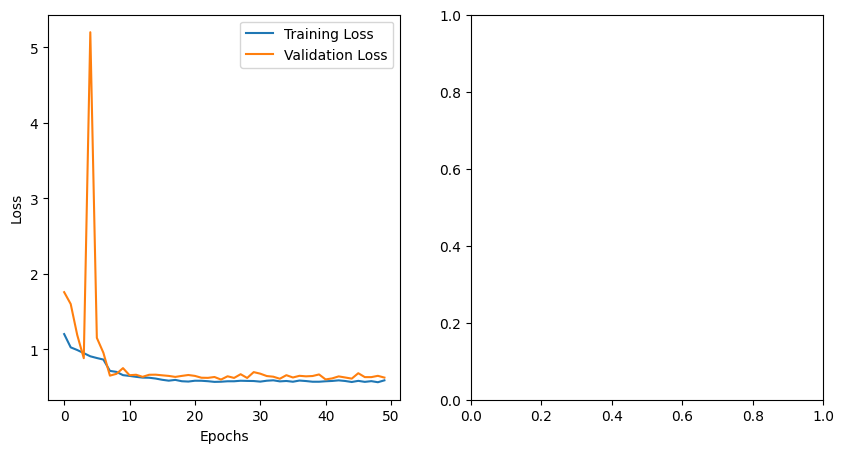

In [11]:
# define training function
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_acc.append(epoch_acc)

            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, train_acc, valid_acc

# begin train
num_epochs = 50
model, train_losses, valid_losses, train_acc, valid_acc = train_model(model, criterion, optimizer, scheduler, num_epochs)

# plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training Accuracy")
plt.plot(valid_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [12]:
torch.save(model.state_dict(), "0512GradCAM-SE.pth") # 只保存模型的参数
torch.save(model, "0512GradCAM-SE.pth.pth") # 保存整个模型

## Grad-CAM

In [18]:
# Grad-CAM function
def create_heatmap(img_path, model):
    img = Image.open(img_path).convert("RGB")
    transformed_img = data_transforms["valid"](img).unsqueeze(0)
    model.eval()
    inputs = transformed_img.to(device)
    inputs = Variable(inputs, requires_grad=True)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # 使用 Grad-CAM 生成熱圖
    cam_extractor = GradCAM(model, model.layer4[-1])
    activation_map = cam_extractor(inputs, preds)

    # 將熱圖疊加到原始圖像上
    heatmap = cv2.applyColorMap(activation_map.cpu().numpy(), cv2.COLORMAP_JET)
    image = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    result = heatmap * 0.3 + image * 0.5

    # 顯示原始圖像和熱圖
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.figure()
    plt.imshow(cv2.cvtColor(result.astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.title("Heatmap")
    plt.axis("off")

    plt.show()

# 選擇一個圖像進行可視化
img_path = "/home/kevinluo/breast_density_classification/ultralytics/data_with_muscle/valid/breast_density1/P_00021_LEFT_CC_1_1_1_jpg.rf.33609ff31a1582e609938c049d949f69.jpg"
create_heatmap(img_path, model)
## 請將img_path替換為您要可視化的圖像路徑。這段代碼將讀取圖像，將其輸入到模型中，
## 使用 Grad-CAM 生成熱圖，並將熱圖疊加到原始圖像上。

AssertionError: Inputs need to be forwarded in the model for the conv features to be hooked

### 試試DenseNet + SE-attention

In [ ]:
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchcam.methods import GradCAM



# data folder path
data_dir = "/home/kevinluo/breast_density_classification/ultralytics/data_with_muscle"

# pre-processing
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((1280, 1280)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}